In [1]:
# Load libraries
import tensorflow as tf
import cv2
import random
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/home/yingjie/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Basic Functions:
def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x,name):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME',name=name)
 

def weight_variable(shape,varname):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=varname)


def bias_variable(shape,varname):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=varname)

In [3]:
# Build ConvNet
def deepnn(x):
    # x is 240x240x1
    
    # First Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([5, 5, 1, 4],'conv_w')
        b_conv1 = bias_variable([4],'conv_b')
        h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1,name='h_conv_op')
        h_pool1 = max_pool_2x2(h_conv1,'h_pool_op')
    # output: 120x120x4
 
    # Second Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([5, 5, 4, 8],'conv_w')
        b_conv2 = bias_variable([8],'conv_b')
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2,name='h_conv_op')
        h_pool2 = max_pool_2x2(h_conv2,'h_pool_op')
    # output: 60x60x8

    # Third Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([5, 5, 8, 16],'conv_w')
        b_conv3 = bias_variable([16],'conv_b')
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3,name='h_conv_op')
        h_pool3 = max_pool_2x2(h_conv3,'h_pool_op')
    # output: 30x30x16

    # First Fully Connected Layer
    with tf.name_scope('fc'):
        # Flatten output from previous layer
        h_pool3_flat = tf.reshape(h_pool3, [-1, 30*30*16])
        # Fully connected + Relu
        # input: flat (30x30x16) = 1x14400
        W_fc1 = weight_variable([30 * 30* 16, 1024],'fc_w')
        b_fc1 = bias_variable([1024],'fc_b')
        h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
    # output: 1x1024
    
    # Dropout
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32,name="keep_prob")
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Output Softmax Layer: Map the 1024 features to 8 classes, one for each class type
    with tf.name_scope('sm'):
        W_sm = weight_variable([1024, 8],'sm_w')
        b_sm = bias_variable([8],'sm_b')
        y_conv_out = tf.add(tf.matmul(h_fc1_drop, W_sm), b_sm, name="y_conv_op")
 
    return y_conv_out,keep_prob

In [4]:
# Extra functions:
# DataSet class to handle images 
class DataSet(object):
    def __init__(self, images, labels):
        self._num_examples = len(images)
        self._images = images
        self._labels = labels
        self._epochs_done = 0
        self._index_in_epoch = 0
        np.random.seed(123456)
        # Shuffle the data
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._images = self._images[perm]
        self._labels = self._labels[perm]
        random.seed(123456)
    @property
    def images(self):
        return self._images
    @property
    def labels(self):
        return self._labels
    @property
    def num_examples(self):
        return self._num_examples
    @property
    def epochs_done(self):
        return self._epochs_done
    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # After each epoch we update this
            self._epochs_done += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm] 
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
    
        return self._images[start:end], self._labels[start:end]

# read images from a directory
def read_images(path,images,labels,class_num,class_index):
    files = glob.glob(os.path.join(path, '*g'))
    for fl in files:
        image = cv2.imread(fl,0)
        image = image.astype(np.float32)
        image = np.multiply(image, 1.0 / 255.0)
        images.append(image)
        label = np.zeros(class_num)
        label[class_index] = 1.0
        labels.append(label)
    return images,labels

def read_mona(image):
    image = cv2.imread(image,0)
    image = image.astype(np.float32)
    image = np.multiply(image, 1.0 / 255.0)
    return image

Reading images
Finished reading images


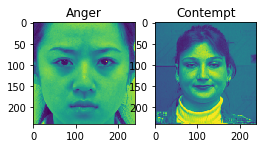

In [5]:
# load training images
images = []
labels = []
testing_images = []
testing_labels = []

# There are eight different possible classifications
print('Reading images')

train_path = '/home/yingjie/Desktop/Machine_Learning/Assignment5/train/'
testing_path = '/home/yingjie/Desktop/Machine_Learning/Assignment5/valid/'

images,labels=read_images(train_path+'anger',images,labels,8,0)
images,labels=read_images(train_path+'contempt',images,labels,8,1)
images,labels=read_images(train_path+'disgust',images,labels,8,2)
images,labels=read_images(train_path+'fear',images,labels,8,3)
images,labels=read_images(train_path+'happiness',images,labels,8,4)
images,labels=read_images(train_path+'neutral',images,labels,8,5)
images,labels=read_images(train_path+'sadness',images,labels,8,6)
images,labels=read_images(train_path+'surprise',images,labels,8,7)

testing_images,testing_labels=read_images(testing_path +'anger',testing_images,testing_labels,8,0)
testing_images,testing_labels=read_images(testing_path +'contempt',testing_images,testing_labels,8,1)
testing_images,testing_labels=read_images(testing_path +'disgust',testing_images,testing_labels,8,2)
testing_images,testing_labels=read_images(testing_path +'fear',testing_images,testing_labels,8,3)
testing_images,testing_labels=read_images(testing_path +'happiness',testing_images,testing_labels,8,4)
testing_images,testing_labels=read_images(testing_path +'neutral',testing_images,testing_labels,8,5)
testing_images,testing_labels=read_images(testing_path +'sadness',testing_images,testing_labels,8,6)
testing_images,testing_labels=read_images(testing_path +'surprise',testing_images,testing_labels,8,7)
print('Finished reading images')

# Create dataset

images = np.array(images)
labels = np.array(labels)
testing_images = np.array(testing_images)
testing_labels = np.array(testing_labels)

train = DataSet(images,labels)
#testing = DataSet(testing_images,testing_labels)

# parameters
model_dir="/home/yingjie/Desktop/Machine_Learning/Facial-expression-detection/"
max_itr=1000
image_size=240

# Inspect Data: Show first image of each type
fig = plt.figure(figsize=(4, 4)) 

ax = fig.add_subplot(121)
plt.imshow(images[0])
ax.set_title('Anger')  

ax = fig.add_subplot(122)
plt.imshow(images[136])
ax.set_title('Contempt')

plt.show()

In [6]:
# ******** Cell - 1 ***********
graph = tf.Graph()
with graph.as_default():   
    # Create the computational graph:
    # Placeholders:
    x = tf.placeholder(tf.float32, [None, image_size,image_size,1],name="x")  # Image dimensions are 240x240x1
    y = tf.placeholder(tf.float32, [None, 8],name="y")  # There are eight possible classes
        
    # Build the graph for the deep net
    y_conv_out,keep_prob = deepnn(x)
    
    # Add loss, accuracy and optimization
    probs=tf.nn.softmax(logits=y_conv_out, name="probs_op")
    
    with tf.name_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=y_conv_out)
        cross_entropy = tf.reduce_mean(cross_entropy, name="cross_entropy")
    
    with tf.name_scope('adam_optimizer'):
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv_out, 1), tf.argmax(y, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction, name="acc_op")
        
    # Add a saver to save the trained model 
    saver=tf.train.Saver(save_relative_paths=True)

In [7]:
batch_size = 32

In [9]:
# ******** Cell - 2 ***********
# Reset graph: useful for multiple runs (e.g., parameter tuning, CV, etc.)
tf.reset_default_graph()  
# Create session to execute graph
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(max_itr):
        # Save a version of the model every 100 iterations
        if i>0 and i%100==0:
            saver.save(sess, "./model", global_step=i)
            
        # Get a batch of 32 images    
        x_batch, y_true_batch = train.next_batch(batch_size)
        x_batch = np.reshape(x_batch, [batch_size,image_size,image_size,1])
        
        
        # Get training accuracy on the batch
        if i>0 and i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: x_batch , y: y_true_batch, keep_prob: 1.0})
            train_err = cross_entropy.eval(feed_dict={x:x_batch, y:y_true_batch, keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
            print('step %d, training loss %g' % (i, train_err))
            
        # Train
        train_step.run(feed_dict={x: x_batch, y: y_true_batch, keep_prob: 0.5})
    
    # save final model
    save_path = saver.save(sess, "./model", global_step=max_itr)
    print("Model saved in file: %s" % save_path)
    
    # Get training accuracy on all training images
    len_image = len(images)
    images = np.reshape(images, [len_image,image_size,image_size,1])
    train_accuracy=accuracy.eval(feed_dict={x: images, y: labels, keep_prob: 1.0 })
    train_err = cross_entropy.eval(feed_dict={x:images, y: labels, keep_prob: 1.0})
    print ("Training Accuracy: %10.5f"%train_accuracy)
    print ("Training Loss: %10.5f"%train_err)

step 100, training accuracy 0.375
step 100, training loss 1.76672
step 200, training accuracy 0.4375
step 200, training loss 1.72344
step 300, training accuracy 0.625
step 300, training loss 1.33928
step 400, training accuracy 0.4375
step 400, training loss 1.65557
step 500, training accuracy 0.65625
step 500, training loss 1.24565
step 600, training accuracy 0.6875
step 600, training loss 1.08118
step 700, training accuracy 0.625
step 700, training loss 1.20891
step 800, training accuracy 0.65625
step 800, training loss 1.15239
step 900, training accuracy 0.59375
step 900, training loss 1.27001
Model saved in file: ./model-1000
Training Accuracy:    0.65138
Training Loss:    1.05539


In [10]:
# ******** Cell - 3 ***********
# Test model on validation data
model_dir2 = "/home/yingjie/Desktop/Machine_Learning/Assignment5/"
len_testing = len(testing_images)

testing_images = np.reshape(testing_images, [len_testing,240,240,1])
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('./model-%s.meta'%(max_itr))
    saver.restore(sess,tf.train.latest_checkpoint(model_dir2))
    graph = tf.get_default_graph()
    
    x = graph.get_tensor_by_name("x:0")
    y = graph.get_tensor_by_name("y:0")
    keep_prob= graph.get_tensor_by_name("dropout/keep_prob:0") 
    accuracy = graph.get_tensor_by_name("accuracy/acc_op:0")
    cross_entropy = graph.get_tensor_by_name("loss/cross_entropy:0")
    
    acc_testing=accuracy.eval(feed_dict={x: testing_images,y: testing_labels, keep_prob: 1.0 })
    err_testing=cross_entropy.eval(feed_dict={x:testing_images, y: testing_labels, keep_prob: 1.0})
    
    print ("Testing Accuracy: %10.5f"%acc_testing)
    print ("Testing Cross-Entropy Loss: %10.5f"%err_testing)

INFO:tensorflow:Restoring parameters from /home/yingjie/Desktop/Machine_Learning/Assignment5/model-1000
Testing Accuracy:    0.55932
Testing Cross-Entropy Loss:    1.42727


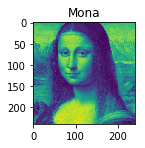

In [11]:
from PIL import Image
mona_path = '/home/yingjie/Desktop/Machine_Learning/Facial-expression-detection/images/'
mona = Image.open(mona_path +'MonaList.jpg')
mona = mona.save(mona_path +'Mona.png')

mona = read_mona(mona_path+'Mona.png')
mona = np.array(mona)


# Inspect Data: Show first image of each type
fig = plt.figure(figsize=(4, 4)) 

ax = fig.add_subplot(121)
plt.imshow(mona)
ax.set_title('Mona')  

plt.show()

mona = np.reshape(mona, [1,240,240,1])

In [12]:
# Create dummy array to feed in as y variable
mona_label = [0,0,0,0,0,0,0,1]
mona_label = np.array(mona_label)
mona_label = np.reshape(mona_label, [1,8])

In [13]:
# Test model on Mona Lisa
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('./model-%s.meta'%(max_itr))
    saver.restore(sess,tf.train.latest_checkpoint(model_dir2))
    graph = tf.get_default_graph()

    x = graph.get_tensor_by_name("x:0")
    y = graph.get_tensor_by_name("y:0")
    keep_prob= graph.get_tensor_by_name("dropout/keep_prob:0") 
    probs = graph.get_tensor_by_name("probs_op:0")
    
    probabilities = sess.run(probs,feed_dict={x:mona,y:mona_label,keep_prob:1})
    
    #print (probabilities)
    print ("Anger: %10.5f"%probabilities[0][0])
    print ("Contempt: %10.5f"%probabilities[0][1])
    print ("Disgust: %10.5f"%probabilities[0][2])
    print ("Fear: %10.5f"%probabilities[0][3])
    print ("Happiness: %10.5f"%probabilities[0][4])
    print ("Neutral: %10.5f"%probabilities[0][5])
    print ("Sadness: %10.5f"%probabilities[0][6])
    print ("Surprise: %10.5f"%probabilities[0][7])
    

INFO:tensorflow:Restoring parameters from /home/yingjie/Desktop/Machine_Learning/Assignment5/model-1000
Anger:    0.15334
Contempt:    0.00951
Disgust:    0.09784
Fear:    0.01511
Happiness:    0.22388
Neutral:    0.42694
Sadness:    0.03522
Surprise:    0.03816
